## Helper: visualize a single xyt configuration

In [1]:
## Imports
import sys
sys.path.insert(0, '../core')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

import kaggle_support as kgs
import pack_vis
import pack_ga
def visualize_xyt(xyt, ax=None, title=None):
    """Visualize an (N_trees,3) xyt array using pack_vis.
    Accepts numpy or cupy arrays.
    """
    if hasattr(xyt, 'get'):
        xyt = xyt.get()
    else:
        xyt = np.asarray(xyt)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    tree_list = kgs.TreeList()
    tree_list.xyt = xyt
    pack_vis.plot_polygons(tree_list.get_trees(), ax=ax)
    if title:
        ax.set_title(title)
    return ax

local
local
stop final relax at some point


## Test 1 — Identical configurations should yield zero distance

In [2]:
N_trees = 6
np.random.seed(42)
ref = np.random.uniform(-1,1,size=(N_trees,3)).astype(np.float32)
ref[:,2] = np.random.uniform(-np.pi, np.pi, size=N_trees)
N_pop = 4
pop = np.tile(ref, (N_pop,1,1))
pop_gpu = cp.array(pop, dtype=cp.float32)
ref_gpu = cp.array(ref, dtype=cp.float32)
d = pack_ga.compute_genetic_diversity(pop_gpu, ref_gpu)
print('Distances (should be ~0):', d.get())

Distances (should be ~0): [0. 0. 0. 0.]


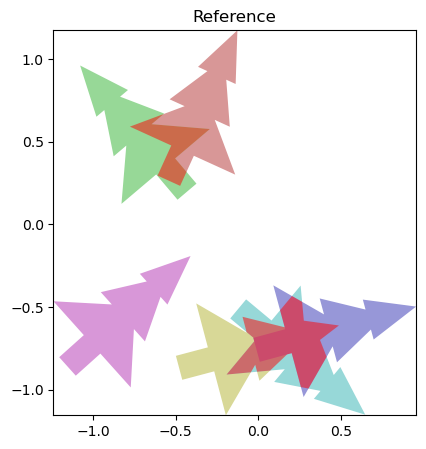

In [3]:
# Visualize the reference
fig, ax = plt.subplots(figsize=(5,5))
visualize_xyt(ref, ax=ax, title='Reference')
plt.show()

## Test 2 — Symmetry (rotations & mirror) should match the reference

In [4]:
def rotate_xyt(xyt, angle):
    out = xyt.copy()
    c, s = np.cos(angle), np.sin(angle)
    x, y = xyt[:,0], xyt[:,1]
    out[:,0] = x*c - y*s
    out[:,1] = x*s + y*c
    out[:,2] = xyt[:,2] + angle
    return out

def mirror_xyt(xyt):
    out = xyt.copy()
    out[:,1] = -out[:,1]
    out[:,2] = -out[:,2]
    return out

# prepare transforms
transformed = [ref, rotate_xyt(ref, np.pi/2), rotate_xyt(ref, np.pi), rotate_xyt(ref, 3*np.pi/2), mirror_xyt(ref), rotate_xyt(mirror_xyt(ref), np.pi/2)]
pop_t = np.stack(transformed, axis=0).astype(np.float32)
d2 = pack_ga.compute_genetic_diversity(cp.array(pop_t), ref_gpu)
print('Symmetry distances (should be ~0):', d2.get())

Symmetry distances (should be ~0): [0.0000000e+00 1.4305115e-06 1.4305115e-06 1.4305115e-06 0.0000000e+00
 2.3841858e-07]


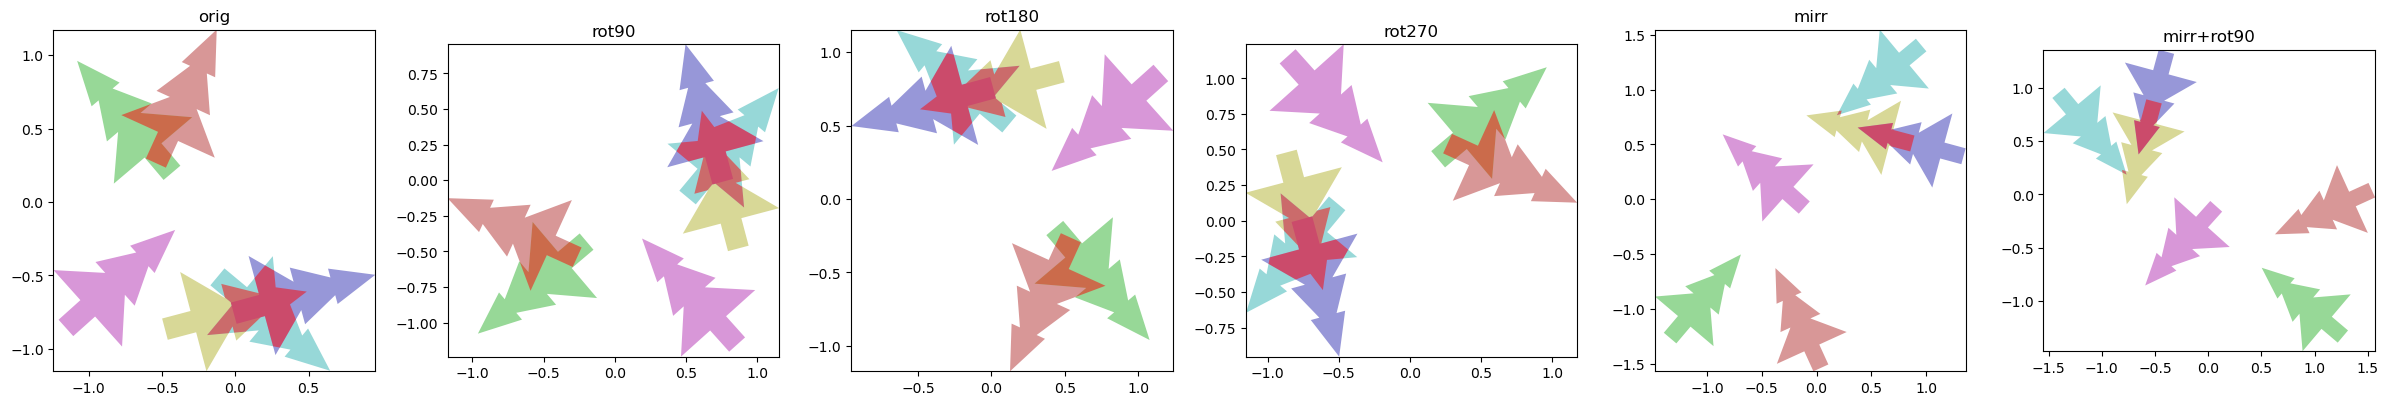

In [5]:
# Visualize them
fig, axes = plt.subplots(1, len(transformed), figsize=(4*len(transformed),4))
titles = ['orig','rot90','rot180','rot270','mirr','mirr+rot90']
for ax, cfg, t in zip(axes, transformed, titles):
    visualize_xyt(cfg, ax=ax, title=t)
plt.tight_layout(); plt.show()

## Test 3 — Permuted tree order shouldn't change distance

Permuted distances (should be ~0): [0. 0. 0. 0. 0.]


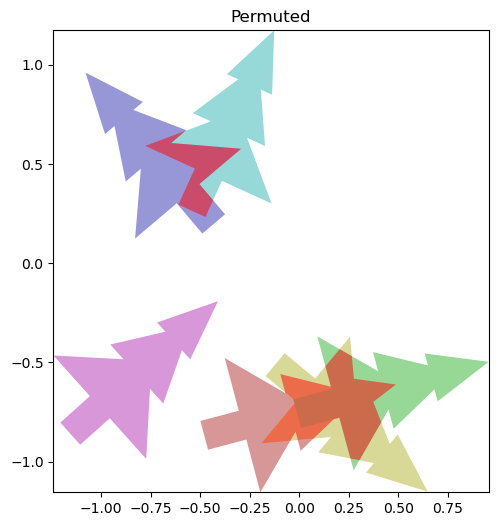

In [13]:
np.random.seed(123)
N_pop = 5
pop_perm = np.zeros((N_pop, N_trees, 3), dtype=np.float32)
for i in range(N_pop):
    p = np.random.permutation(N_trees)
    pop_perm[i] = ref[p]
d3 = pack_ga.compute_genetic_diversity(cp.array(pop_perm), ref_gpu)
print('Permuted distances (should be ~0):', d3.get())
visualize_xyt(pop_perm[0], ax=None, title='Permuted')
plt.show()

## Test 4 — Random configurations have positive distances

In [7]:
np.random.seed(999)
N_pop = 8
pop_rand = np.random.uniform(-2,2,size=(N_pop, N_trees, 3)).astype(np.float32)
pop_rand[:,:,2] = np.random.uniform(-np.pi, np.pi, size=(N_pop,N_trees))
d4 = pack_ga.compute_genetic_diversity(cp.array(pop_rand), ref_gpu)
print('Random distances:', d4.get())
print('min, max, mean:', float(d4.min().get()), float(d4.max().get()), float(d4.mean().get()))

Random distances: [ 7.7034664  7.1046786 10.197632   8.990243   6.9559665  8.483187
  8.144677   9.86119  ]
min, max, mean: 6.955966472625732 10.1976318359375 8.430130004882812


## Test 5 — Distance vs. increasing noise

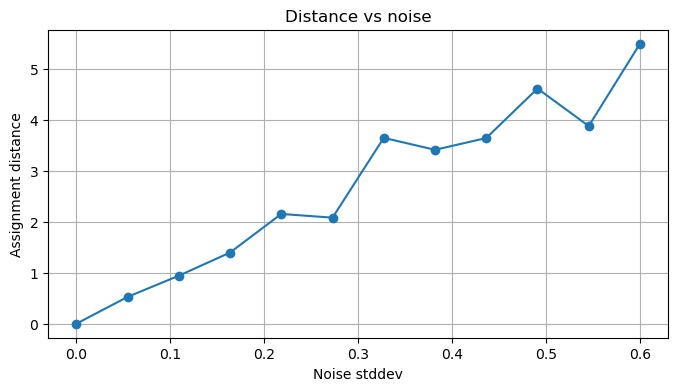

In [8]:
noise_levels = np.linspace(0,0.6,12)
pop_noise = np.zeros((len(noise_levels), N_trees, 3), dtype=np.float32)
np.random.seed(42)
for i, n in enumerate(noise_levels):
    cfg = ref.copy()
    cfg[:,:2] += np.random.normal(0, n, size=(N_trees,2))
    cfg[:,2] += np.random.normal(0, n, size=N_trees)
    pop_noise[i] = cfg
d5 = pack_ga.compute_genetic_diversity(cp.array(pop_noise), ref_gpu)
plt.figure(figsize=(8,4))
plt.plot(noise_levels, d5.get(), 'o-')
plt.xlabel('Noise stddev'); plt.ylabel('Assignment distance')
plt.title('Distance vs noise')
plt.grid(True); plt.show()

## Test 6 — Larger configuration (scalability smoke test)

In [9]:
N_trees_large = 20
N_pop_large = 30
np.random.seed(1)
ref_large = np.random.uniform(-3,3,size=(N_trees_large,3)).astype(np.float32)
ref_large[:,2] = np.random.uniform(-np.pi, np.pi, size=N_trees_large)
pop_large = np.zeros((N_pop_large, N_trees_large,3), dtype=np.float32)
for i in range(N_pop_large):
    pop_large[i] = ref_large.copy()
    pop_large[i,:,:2] += np.random.normal(0, i*0.02, size=(N_trees_large,2))
    pop_large[i,:,2] += np.random.normal(0, i*0.02, size=N_trees_large)
# compute and time
import time
start = time.time()
d6 = pack_ga.compute_genetic_diversity(cp.array(pop_large), cp.array(ref_large))
cp.cuda.Stream.null.synchronize()
elapsed = time.time() - start
print(f'Large test time: {elapsed:.3f}s')
print('distance range:', float(d6.min().get()), float(d6.max().get()))

Large test time: 5.362s
distance range: 1.6689300537109375e-06 20.372493743896484


---
Run the notebook cells sequentially; ensure you have `cupy` installed and a working GPU and/or `cugraph` available.